# 室内场景三维重建 - 课程大作业


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# 导入必要的库
import cv2
from pathlib import Path
from process import *
import process.feature_extraction as fe
import process.feature_matching as fm
from util import *

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [3]:
# 初始化数据保存路径
data_path = Path.cwd() / "data"

## Step0: 导入图像及相机参数


In [4]:
# 是否重新生成数据
regenerate = False
cache_key = "images_and_intrinsics"

images, camera_intrinsic = cache_wrapper(
    cache_key, regenerate, load_images_and_camera_intrinsic
)(data_path)

### 测试：展示图像和相机参数


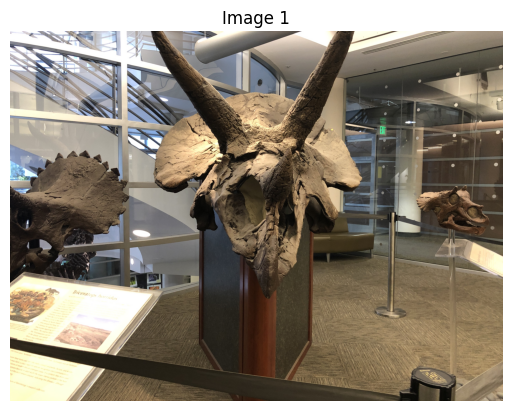

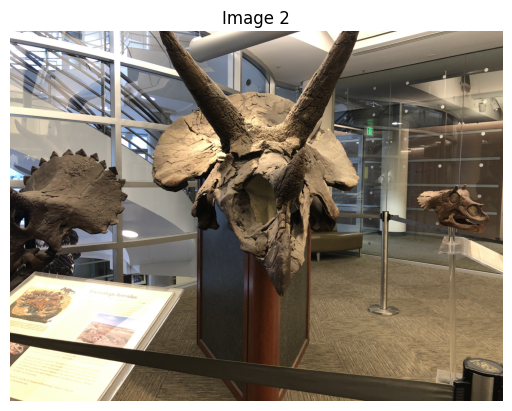

相机内参矩阵:
[[3.2256e+03 0.0000e+00 2.0160e+03]
 [0.0000e+00 3.2256e+03 1.5120e+03]
 [0.0000e+00 0.0000e+00 1.0000e+00]]


In [5]:
# 展示读取的图像
for i, img in enumerate(images[:2]):
    plt_show(img, f"Image {i+1}")

# 展示相机内参
print("相机内参矩阵:")
print(camera_intrinsic)

## Step1: 图像特征提取 (SIFT)


In [6]:
regenerate = False
data_cache_key = "sift"

# 运行SIFT特征提取
features = cache_wrapper(
    data_cache_key,
    regenerate,
    extract_features,
    fe.after_load,
)(images)

### 测试：展示图像特征点


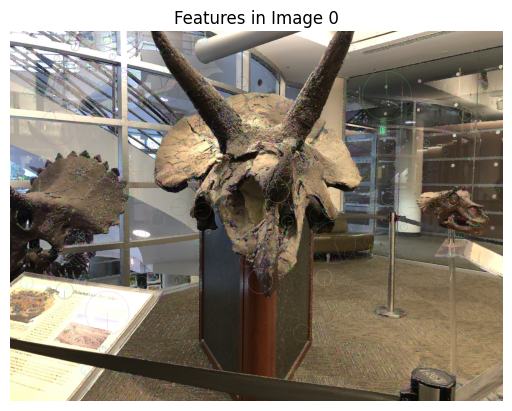

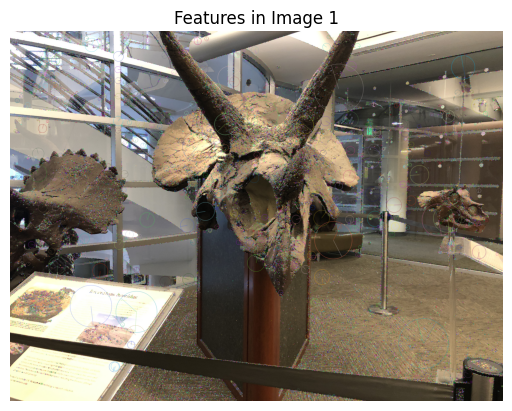

In [7]:
# 展示特征点
for i, img in enumerate(images[:2]):
    img_with_features = cv2.drawKeypoints(
        img, features[i][0], None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
    )
    plt_show(img_with_features, f"Features in Image {i}")

## Step2: 图像特征匹配


In [8]:
# 是否要重新生成该部分数据
regenerate = False
data_cache_key = "matches"

# 运行特征匹配
all_matches = cache_wrapper(
    data_cache_key, regenerate, match_all_paires, fm.after_load
)(features)

100%|██████████| 61/61 [03:25<00:00,  3.36s/it]

数据已保存到缓存: matches


### 测试：展示匹配结果


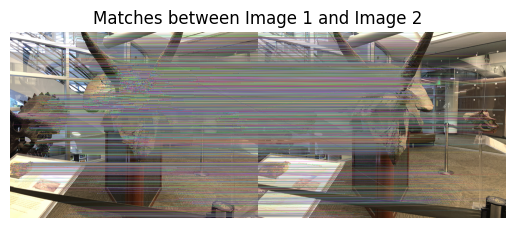

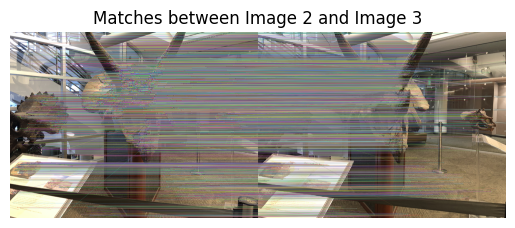

In [9]:
for i, (img1, img2) in enumerate(zip(images[:2], images[1:3])):
    img_matches = visualize_matches(
        img1, img2, all_matches[(i, i + 1)], features[i], features[i + 1]
    )
    plt_show(img_matches, f"Matches between Image {i+1} and Image {i+2}")

## Step2.5: 初始化相机


In [45]:
cameras = []
for i, img in enumerate(images):
    camera = Camera(camera_intrinsic)
    cameras.append(camera)

## Step3: 场景初始化 (对极几何)


In [46]:
# 初始化重建
points3D = init_recon(
    features1=features[0],
    features2=features[1],
    camera1=cameras[0],
    camera2=cameras[1],
    match=all_matches[(0, 1)],
)

基础矩阵:
[[ 2.21629236e-08  8.74351252e-07  6.96052185e-04]
 [-5.77849412e-07 -3.94537224e-08  2.77009734e-02]
 [-1.20131671e-03 -2.81700818e-02  1.00000000e+00]]

本质矩阵:
[[  0.23059404   9.09718355   6.65361199]
 [ -6.01223152  -0.41049607  85.40219492]
 [ -6.54907943 -85.37209619   0.17576819]]

旋转矩阵:
[[ 0.99933657  0.00159068 -0.0363852 ]
 [-0.00149234  0.99999516  0.00272968]
 [ 0.03638937 -0.00267357  0.99933411]]

平移向量:
[[ 0.99134408]
 [-0.07745295]
 [ 0.10600926]]



### 测试：展示初始化结果


In [47]:
# 展示相机位置和点云
visualize_camera_pose_and_pcd(
    [cameras[1].get_pose()], points3D[cameras[0].matched_indices_3D]
)

[Open3D WARNING] GLFW Error: WGL: Failed to make context current: 不支持请求的转换操作。 


## Step4: 场景重建 (PnP)


In [ ]:
# 执行PnP算法来估计相机姿态
points3D_pnp, cameras_pnp = perform_PnP(
    points3D, features, cameras, all_matches, added_camera_num=10
)

100%|██████████| 60/60 [00:01<00:00, 52.02it/s]


### 测试：展示重建结果


In [56]:
# 展示相机位置和点云
camera_poses = [camera.get_pose() for camera in cameras_pnp[1:]]
visualize_camera_pose_and_pcd(camera_poses, points3D_pnp)

[Open3D WARNING] [ViewControl] SetViewPoint() failed because window height and width are not set.


## Step5: 场景优化 (Bundle Adjustment)


In [ ]:
# # 执行BA算法来优化相机姿态和点云
# optimized_points3D = perform_BA_on_all(points3D=points3D, cameras=cameras[1:])

In [ ]:
# # 保存优化后的点云数据
# dc.save("optimized_points3D", optimized_points3D)
# dc.save("cameras", cameras)

In [ ]:
# 加载优化后的点云数据
optimized_points3D = dc.load("optimized_points3D")
cameras = dc.load("cameras")

In [ ]:
# 展示优化后的相机位置和点云
visualize_camera_pose_and_pcd(
    [camera.get_pose() for camera in cameras[1:]], optimized_points3D
)